## **Deep Learning Made Easy**

----

**Important:** This notebook is an official <a href="https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html">PyTorch tutorial</a> developed by <a href="https://github.com/inkawhich">Nathan Inkawhich</a> and some modifications have been done by <a href="https://www.linkedin.com/in/valdivino-alexandre-de-santiago-j%C3%BAnior-103109206/?locale=en_US">Valdivino Alexandre de Santiago Júnior</a>. It is a notebook addressing the deep convolutional generative adversarial network (<a href="https://arxiv.org/abs/1511.06434">DCGAN</a>).

<br>

**Licence**: GNU GENERAL PUBLIC LICENSE, Version 3 (GPLv3)

##Generative Adversarial Networks (GANs)
----


GANs are a framework for generative models via an adversarial process <a href="https://arxiv.org/abs/1406.2661">[Goodfellow et al. 2014]</a>. Two models are trained: a generative model, $G$, that captures the data distribution, and a discriminative model, $D$, that estimates the probability that a sample came from the training data rather than $G$.

<br>

The generator ($G$) is like a counterfeiter, trying to make fake money, and the discriminator ($D$) is like the
police, trying to allow legitimate money and catch counterfeit money. It is a two-player game where the counterfeiter must learn to make (fake) money that resembles very much genuine money, and the generator ($G$) must learn to
create samples that are drawn from the same distribution as the training data <a href="https://arxiv.org/abs/1701.00160">[Goodfellow 2016]</a>. In other words, we train two networks simultaneously.

<br>

<img src="https://drive.google.com/uc?id=1Hn_V-ksi_de1cLOAnuFhjJjMZdbGn57v" alt="Drawing" width="400"/>

Source: <a href="https://www.deeplearningbook.com.br/">Data Science Academy</a>.

<br>










 









In [ ]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/pyTorch/dlme

/content/drive/My Drive/Colab Notebooks/pyTorch/dlme


## **Create directory and unzip the dataset**
----

Create the following directory under the "root" directory:



1.   ```celeba```. It will contain the <a href="http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html">CelebFaces Attributes</a>  dataset which is a large-scale face attributes dataset with more than 200K (precisely 202,599 images) celebrity images, each with 40 attribute annotations.

<br>

After that, run the command below only once to unzip the dataset. It is assumed that the .zip file (img_align_celeba.zip) has already been uploaded to the "root" Google Drive's directory.

In [ ]:
#!unzip "/content/drive/My Drive/Colab Notebooks/pyTorch/dlme/img_align_celeba.zip" -d "/content/drive/My Drive/Colab Notebooks/pyTorch/dlme/celeba"

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from prettytable import PrettyTable

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
# This function obtains the number of trainable parameters of the 
# model/network.
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total trainable params: {total_params}")
    return total_params

##Latent variable
----

A latent variable is a synonym for a hidden variable. Hence, we cannot truly see it. For instance, in a standard feed-forward neural network, we cannot manipulate the values output by hidden layers.

<br>

Moreover, note the concept of sampling a distribution. For instance, the instruction

 ```z1 = np.random.uniform(-1, 1, nsamples)``` 
 
 means that you are sampling ```z1``` from a uniform distribution. Moreover, ```nsamples``` is the number of samples. 

<br>

Likewise, the instructions below

```mu, sigma = 0, 1 # mean and standard deviation```

```z2 = np.random.normal(mu, sigma, nsamples)```

mean that you are sampling ```z2``` from a standard normal distribution (mean = 0; variance = standard deviation = 1). 










 








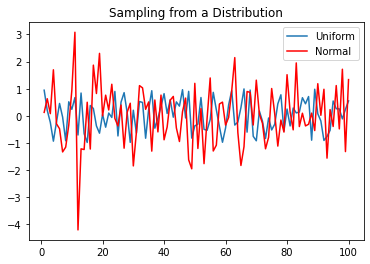

In [ ]:
nsamples = 100

# Uniform
z1 = np.random.uniform(-1, 1, nsamples)
x = range(1,len(z1)+1)

# Normal (Gaussian)
mu, sigma = 0, 1 # mean and standard deviation
z2 = np.random.normal(mu, sigma, nsamples)

plt.title("Sampling from a Distribution")
plt.plot(x,z1,label="Uniform")
plt.plot(x,z2,label="Normal",color='r')
plt.legend()
plt.show()

##Discriminator and Generator: Theory
----

Let $x$ be data representing an image.
$D(x)$ is the discriminator network which outputs the (scalar)
probability that $x$ came from training data rather than the
generator (i.e. generator's distribution $p_g$). Here, since we are dealing with images the input to
$D(x)$ is an image of CHW size 3x64x64. Intuitively, $D(x)$
should be **HIGH** when $x$ comes from the training data and **LOW** when
$x$ comes from the generator. $D(x)$ can also be thought of
as a traditional binary classifier (real $\times$ fake).

<br>

As for the generator’s notation, let $z$ be a **latent space vector**
sampled from a standard normal distribution. $G(z)$ represents the
generator function which maps the latent vector $z$ to the data space.
The goal of $G$ is to estimate the distribution that the training
data comes from $p_{data}$ so it can generate fake samples from
that estimated distribution ($p_g$).

<br>


So, $D(G(z))$ is the probability (scalar) that the output of the
generator $G$ is a real image.
$D$ and $G$ play a minimax game in which $D$ tries to
**maximise** the probability it correctly classifies reals and fakes
($logD(x)$), and $G$ tries to **minimise** the probability that
$D$ will predict its outputs are fake ($log(1-D(G(z)))$).

<br>

The GAN loss function is  <a href="https://arxiv.org/abs/1406.2661">[Goodfellow et al. 2014]</a>:

\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}

<br>

In theory, this minimax game has a global optimum for $p_g = p_{data}$. In other words, after enough of training, if $G$ and $D$ have enough capacity, they will reach a
point at which both cannot improve because $p_g$ = $p_{data}$. Hence, the discriminator is unable to differentiate between the two distributions, i.e. $D(x) = \frac{1}{2}$. To sum up, the discriminator guesses randomly if the
inputs are real or fake. 

In [ ]:
# Here, we will create (see later) a noise with b_size x 1 x 1 x nsamples
# TORCH.RANDN: Returns a tensor filled with random numbers from a normal 
# distribution with mean 0 and variance 1 (also called the standard normal 
# distribution).

b_size = 128
noise = torch.randn(b_size, nsamples, 1, 1)
print("Shape of the noise - Generator:", noise.shape)

Shape of the noise - Generator: torch.Size([128, 100, 1, 1])


##DCGAN
----

A <a href="https://arxiv.org/abs/1511.06434"> DCGAN</a> is a direct extension of the GAN described above, except that it
explicitly uses convolutional and convolutional-transpose layers in the
discriminator and generator, respectively. The discriminator
is made up of strided convolution and batch normalisation layers, and uses LeakyReLU activation functions.

<br>

The input is a 3x64x64 input image and the output is a
scalar probability that the input is from the real data distribution.

<br>


The generator is comprised of convolutional-transpose and batch normalisation layers, and ReLU are the activation functions (except output layer which is Tanh). The
input is a **latent vector**, $z$, that is drawn from a **standard
normal distribution** (see above) and the output is a 3x64x64 RGB image. The strided
conv-transpose layers allow the latent vector to be transformed into a
volume with the same shape as an image. 

<br>

To sum up, architecture guidelines for stable DCGANs are (as in the DCGAN article):

1. Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (transposed convolutions; generator). Replacing deterministic spatial
pooling functions (such as maxpooling) with strided convolutions, allows the network to learn
its own spatial downsampling;
2. Use batch normalisation in both the generator and the discriminator. Batch normalisation stabilizes learning by normalising the
input to each unit to have zero mean and unit variance. Dealing with training problems (poor initialisation) and helps gradient flow in deeper models;
3. Remove fully-connected (FC) hidden layers for deeper architectures;
4. Use ReLU activation in generator for all layers except for the output, which uses Tanh;
5. Use LeakyReLU activation in the discriminator for all layers.









 





##Inputs
-----

Inputs are defined below (it includes some hyper-parameters):

-  **dataroot** - the path to the root of the dataset folder;
-  **workers** - the number of worker threads for loading the data with
   the DataLoader;
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128;
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed;
-  **nc** - number of color channels in the input images;
-  **nz** - length of latent vector (our previous nsamples);
-  **ngf** - relates to the depth of feature maps carried through the
   generator;
-  **ndf** - sets the depth of feature maps propagated through the
   discriminator;
-  **num_epochs** - number of epochs;
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002;
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5;
-  **ngpu** - number of GPUs available.




In [ ]:
# Root directory for dataset
dataroot = "celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
# size using a transformer.
image_size = 64

# Number of channels in the training images. 
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20 

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

##Handling the Data
----

Load the data and show some training (true) images.

2
image:  0  - inp shape:  torch.Size([128, 3, 64, 64])
image:  1  - inp shape:  torch.Size([128])


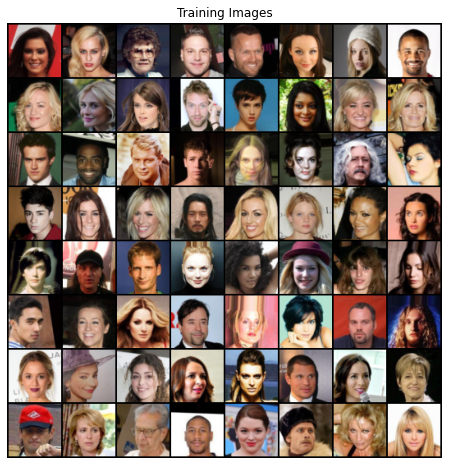

In [ ]:
dataset = dset.ImageFolder(root=dataroot,
                          transform=transforms.Compose([
                          transforms.Resize(image_size),
                          transforms.CenterCrop(image_size),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
print(len(real_batch))
for i in range(len(real_batch)):
  print('image: ', i, ' - inp shape: ', real_batch[i].shape )

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

##Weight Initialisation
----

According to the DCGAN article, "All weights were initialized from a zero-centered Normal distribution
with standard deviation 0.02. In the LeakyReLU, the slope of the leak was set to 0.2 in all models."

<br>

Thus, the ``weights_init`` function takes an initialised model as
input and reinitialises all convolutional, convolutional-transpose, and
batch normalisation layers to meet this criteria. This function is
applied to the models immediately after initialisation.

<br>

PS: Indeed, the function below initialiases only the weights of the conv. layers as proposed in the article. The weights of the batch normalisation layers are initialised from a Normal distribution with mean = 1 and standard deviation 0.02. The bias of the batch layers are initialised with 0.

<br>

Check the description of ```torch.nn.init.normal_``` function:

```torch.nn.init.normal_(tensor, mean=0.0, std=1.0)```

Fills the input Tensor with values drawn from the normal distribution $\mathcal{N}$($\text{mean}$, $\text{std}^2$).








In [ ]:
# custom weights initialisation called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

##Generator: Implementation
----

The generator, $G$, is designed to map the latent space vector
($z$) to data space. Since our data are images, converting
$z$ to data space means creating an RGB image with the
same size as the training images (i.e. 3x64x64). In practice, this is
accomplished through a series of strided two-dimensional convolutional
transpose layers, each paired with a 2D batch normalisation layer and a ReLU
activation. The output of the generator is fed through a Tanh function
to return it to the input data range of $[-1,1]$. An
image of the generator from the DCGAN article is shown below.

<br>


<img src="https://drive.google.com/uc?id=1Ofv3N6FnrrDiz2_JbXncTUoMevzDGlI1" alt="Drawing" width="800"/>

Source: <a href="https://arxiv.org/abs/1511.06434">DCGAN article</a>.

<br>

Notice, how the inputs we set in the input section (*nz*, *ngf*, and
*nc*) influence the generator architecture in code. *nz* is the length
of the z input vector, *ngf* relates to the size of the feature maps
that are propagated through the generator, and *nc* is the number of
channels in the output image (set to 3 for RGB images). 

<br>

In order to understand how the latent space vector, $z$, is tranformed into an n-dimensional data structure, consider the ConvTranspose2d output shape as implemented in PyTorch: 

<br>

$$
H_{out} =(H_{in} −1) \times stride[0]−2 \times padding[0] + dilation[0] \times(kernel\_size[0]−1) + output\_padding[0] + 1
 $$

<br> 

$$
W_{out} =(W_{in} −1) \times stride[1]−2 \times padding[1] + dilation[1] \times(kernel\_size[1]−1) + output\_padding[1] + 1
$$
<br>

The first layer of $G$ has these characteristics:

```ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)```

Thus, stride = 1, padding = 0, dilation = 1, kernel = 4, out_padding = 0. Hence:

$$
H_{out} = W_{out} = (1 −1) \times 1 −2 \times 0 + 1 \times(4−1) + 0 + 1 = 4
$$

<br>

Thus, the output dimension of the first layer is $4 \times 4$.


In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

Now, we can instantiate the generator and apply the ``weights_init``
function. 




In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function 
netG.apply(weights_init)

# Check number of trainable parameters
print('Checking trainable parameters: {}'.format(count_parameters(netG)))

# Print the model
print(netG)

+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| main.0.weight  |   819200   |
| main.1.weight  |    512     |
|  main.1.bias   |    512     |
| main.3.weight  |  2097152   |
| main.4.weight  |    256     |
|  main.4.bias   |    256     |
| main.6.weight  |   524288   |
| main.7.weight  |    128     |
|  main.7.bias   |    128     |
| main.9.weight  |   131072   |
| main.10.weight |     64     |
|  main.10.bias  |     64     |
| main.12.weight |    3072    |
+----------------+------------+
Total trainable params: 3576704
Checking trainable parameters: 3576704
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, aff

##Discriminator: Implementation
----

The discriminator, $D$, is a binary classification
network that takes an image as input and outputs a scalar probability
that the input image is real (as opposed to fake). Here, $D$ takes
a 3x64x64 input image, processes it through a series of Conv2d,
BatchNorm2d, and LeakyReLU layers, and outputs the final probability
through a Sigmoid activation function. 

<br>

Just to stress: regardless of the image (real, fake), the input shape of the discriminator is **3x64x64**.




In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator and apply the
``weights_init`` function.




In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function.
netD.apply(weights_init)

# Check number of trainable parameters
print('Checking trainable parameters: {}'.format(count_parameters(netD)))

# Print the model
print(netD)

+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| main.0.weight  |    3072    |
| main.2.weight  |   131072   |
| main.3.weight  |    128     |
|  main.3.bias   |    128     |
| main.5.weight  |   524288   |
| main.6.weight  |    256     |
|  main.6.bias   |    256     |
| main.8.weight  |  2097152   |
| main.9.weight  |    512     |
|  main.9.bias   |    512     |
| main.11.weight |    8192    |
+----------------+------------+
Total trainable params: 2765568
Checking trainable parameters: 2765568
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 

##Loss Functions and Optimisers
----

We will use the Binary Cross
Entropy loss function which is defined in PyTorch as:

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

Notice how this function provides the calculation of both log components
in the objective function (i.e. $log(D(x))$ and
$log(1-D(G(z)))$). We can specify what part of the BCE equation to
use with the $y$ input. This is accomplished in the training loop
which is coming up soon, but it is important to understand how we can
choose which component we wish to calculate just by changing $y$
(i.e. GT labels).

Next, we define our real label as 1 and the fake label as 0. These
labels will be used when calculating the losses of $D$ and
$G$, and this is also the convention used in the original GAN
paper. Finally, we set up two separate optimisers, one for $D$ and
one for $G$. As specified in the DCGAN article, both are Adam
optimizers with learning rate 0.0002 and Beta1 = 0.5. For keeping track
of the generator’s learning progression, we will generate a fixed batch
of latent vectors that are drawn from a Gaussian distribution
(i.e. fixed_noise). In the training loop, we will periodically input
this fixed_noise into $G$, and over the iterations we will see
images form out of the noise.




In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training
----

 
We will “construct different mini-batches for real and fake”
images, and also adjust G’s objective function to maximise
$logD(G(z))$. In accordance with <a href="https://arxiv.org/abs/1406.2661">[Goodfellow et al. 2014]</a>, this is because the original equation "may not provide sufficient gradient for $G$ to learn well. Early in learning,
when $G$ is poor, $D$ can reject samples with high confidence because they are clearly different from
the training data. In this case, $log(1 - D(G(z)))$ saturates." 

<br>



*Part 1 - Train the Discriminator*

Recall, the goal of training the discriminator is to maximise the
probability of correctly classifying a given input as real or fake. In
terms of Goodfellow, we wish to “update the discriminator by ascending
its stochastic gradient”. Practically, we want to **maximise
$log(D(x)) + log(1-D(G(z)))$**. Due to the separate mini-batch
suggestion from ganhacks, we will calculate this in two steps. First, we
will construct a batch of real samples from the training set, forward
pass through $D$, calculate the loss ($log(D(x))$), then
calculate the gradients in a backward pass. Secondly, we will construct
a batch of fake samples with the current generator, forward pass this
batch through $D$, calculate the loss ($log(1-D(G(z)))$),
and *accumulate* the gradients with a backward pass. Now, with the
gradients accumulated from both the all-real and all-fake batches, we
call a step of the Discriminator’s optimizer.

<br> 

*Part 2 - Train the Generator*

As stated in the original paper, we want to train the Generator by
**minimising $log(1-D(G(z)))$** in an effort to generate better fakes.
As explained above, we indeed want to **maximise** $log(D(G(z)))$. In the code we accomplish
this by: classifying the Generator output from Part 1 with the
Discriminator, computing G’s loss *using real labels as GT*, computing
G’s gradients in a backward pass, and finally updating G’s parameters
with an optimiser step. It may seem counter-intuitive to use the real
labels as GT labels for the loss function, but this allows us to use the
$log(x)$ part of the BCELoss (rather than the $log(1-x)$
part) which is exactly what we want.



<br>

<img src="https://drive.google.com/uc?id=1h29RjkMSg3OO_BVNRovuTrvKUzo_yxrj" alt="Drawing" width="400"/>

Source: <a href="https://arxiv.org/abs/1701.00160">[Goodfellow 2016]</a>.

<br>

Some values during training are printed:

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(1 - D(G(z1)))$);
-  **Loss_G** - generator loss calculated as $log(D(G(z2)))$;
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better; 
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. 

<br>











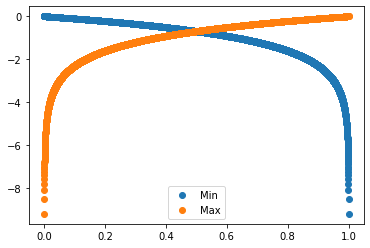

In [ ]:
fig, ax = plt.subplots()
prob = np.arange(0.0001, 1.0, 0.0001)
minF = [np.log(1 - p) for p in prob]
maxF = [np.log(p) for p in prob]
ax.scatter(prob, minF, label='Min')
ax.scatter(prob, maxF, label='Max')
ax.legend()
plt.show()

*Important Remarks about the outputs during training* 

<br>

Remember that $D(x)$, $D(G(z))$ are probabilities!

<br>

$D(x)$, $D(G(z1))$, $D(G(z2))$ are the average values of all 128 images of the mini-batch. 

<br>

$D(x)$: in a perfect world, we would expect a value close to 1 (real images, discriminator performing Ok). 

<br>

$D(G(z1 / z2))$: in a perfect world, we would expect a value close to 0 (fake images; $D(G(z1) = 0)$). But, recall the previous equilibrium remark. 

<br>

Note that "all" passes through $D$ when calculating the losses.





In [ ]:
# Function to check the average values of tensors.
def meanTensor(t):
  meant = torch.sum(t)
  mean = meant.cpu().detach().numpy()
  mean = mean / t.size()
  return mean

In [ ]:
# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
meanDx, meanDGz1, meanDGz2 = 0.0, 0.0, 0.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        meanDx = meanTensor(output) # To be sure

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        meanDGz1 = meanTensor(output) # To be sure
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        meanDGz2 = meanTensor(output) # To be sure
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f -- %.4f\tD(G(z1 / z2)): %.4f -- %.4f / %.4f -- %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, meanDx, D_G_z1, meanDGz1, D_G_z2, meanDGz2))    
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/20][0/356]	Loss_D: 1.7159	Loss_G: 2.1844	D(x): 0.3255 -- 0.3255	D(G(z1 / z2)): 0.2659 -- 0.2659 / 0.1520 -- 0.1520
[0/20][50/356]	Loss_D: 0.0226	Loss_G: 40.4478	D(x): 0.9801 -- 0.9801	D(G(z1 / z2)): 0.0000 -- 0.0000 / 0.0000 -- 0.0000
[0/20][100/356]	Loss_D: 0.0236	Loss_G: 39.0061	D(x): 0.9924 -- 0.9924	D(G(z1 / z2)): 0.0000 -- 0.0000 / 0.0000 -- 0.0000
[0/20][150/356]	Loss_D: 0.0029	Loss_G: 38.5324	D(x): 0.9975 -- 0.9975	D(G(z1 / z2)): 0.0000 -- 0.0000 / 0.0000 -- 0.0000
[0/20][200/356]	Loss_D: 0.0001	Loss_G: 38.0598	D(x): 0.9999 -- 0.9999	D(G(z1 / z2)): 0.0000 -- 0.0000 / 0.0000 -- 0.0000
[0/20][250/356]	Loss_D: 0.0000	Loss_G: 37.0548	D(x): 1.0000 -- 1.0000	D(G(z1 / z2)): 0.0000 -- 0.0000 / 0.0000 -- 0.0000
[0/20][300/356]	Loss_D: 0.0003	Loss_G: 43.5237	D(x): 0.9998 -- 0.9998	D(G(z1 / z2)): 0.0000 -- 0.0000 / 0.0000 -- 0.0000
[0/20][350/356]	Loss_D: 0.0001	Loss_G: 43.3021	D(x): 0.9999 -- 0.9999	D(G(z1 / z2)): 0.0000 -- 0.0000 / 0.0000 -- 0.0000
[1/20][0/3

##Results
-----

We will see how $D$ and $G$’s losses changed
during training. We will also visualise $G$’s output on the fixed-noise
batch for every epoch. Moreover, we will look at a batch of real data
next to a batch of fake data from G.

<br>

*Loss versus training iteration*

Below is a plot of $D$ & $G$’s losses versus training iterations. 
PS: Number of iterations = number of batches $\times$ epochs.




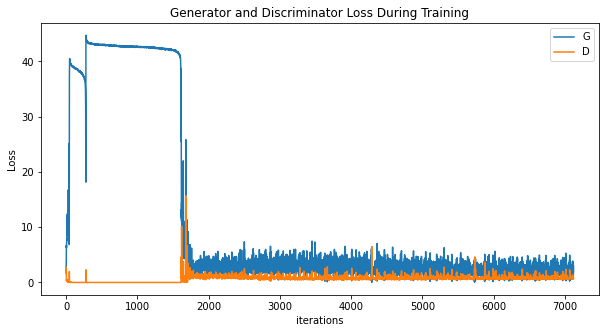

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

##Visualization of G’s progression##
----

We can visualise the training
progression of G with an animation. Press the play button to start the
animation.




In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

##Real Images versus Fake Images
----

Finally, lets take a look at some real images and fake images side by
side.




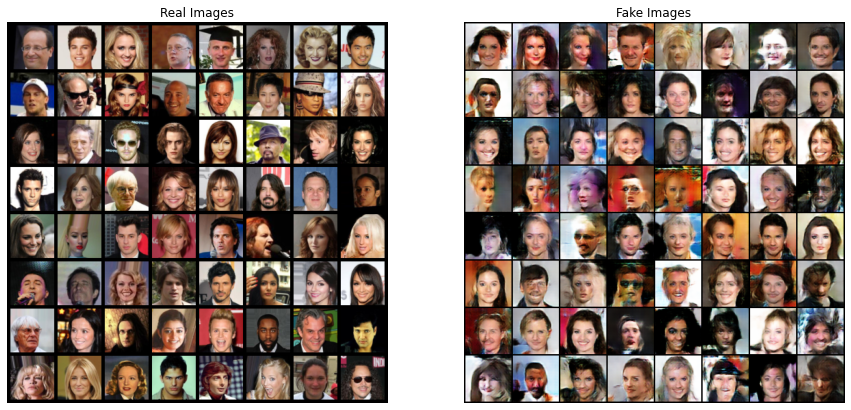

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()